In [1]:
options(repos = c(CRAN = "https://cloud.r-project.org"))

if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, ggplot2, dplyr, lubridate, stringr, readxl, data.table, gdata, scales, data.table)

source("..//functions-1.R")

Loading required package: pacman



In [2]:
data.2014 <- read.csv('../data/output/data-2014.csv')
data.2015 <- read.csv('../data/output/data-2015.csv')
data.2016 <- read.csv('../data/output/data-2016.csv')
data.2017 <- read.csv('../data/output/data-2017.csv')
data.2018 <- read.csv('../data/output/data-2018.csv')
data.2019 <- read.csv('../data/output/data-2019.csv')

In [3]:
data.full <- rbind(data.2014, data.2015, data.2016, data.2017, data.2018, data.2019)

## Problem 1


In [19]:
plan_counts <- data.full %>% 
    group_by(fips, year) %>%
    summarise(plan_count = n(), .groups = "drop")

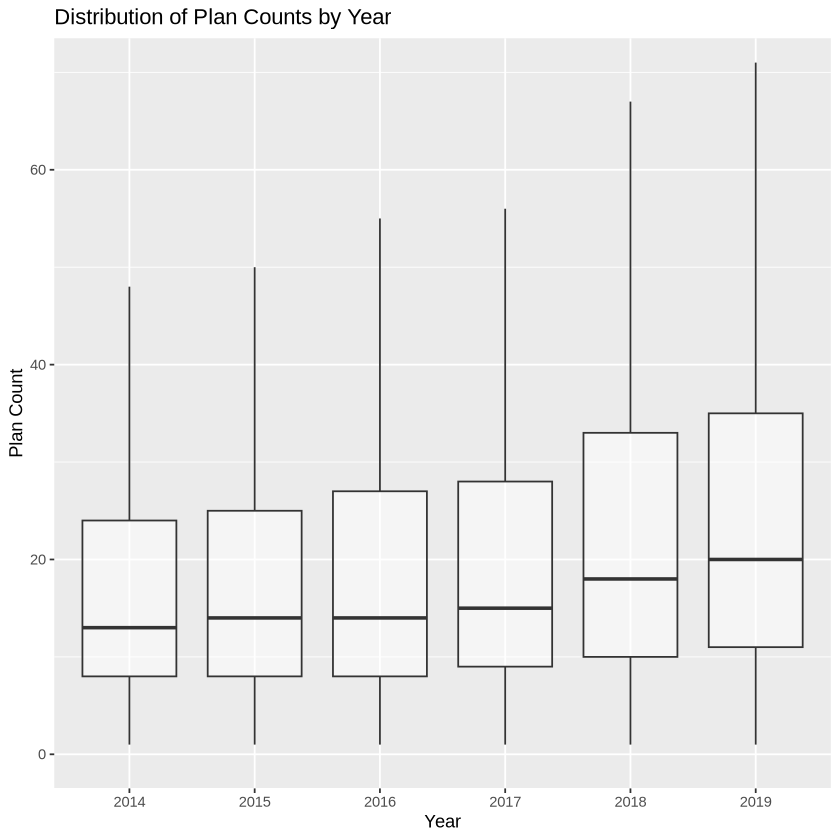

In [30]:
ggplot(plan_counts, aes(x = factor(year), y = plan_count)) +
    geom_boxplot(outlier.shape = NA, alpha = 0.5) + 
    coord_cartesian(ylim = c(0, 70)) +
    labs(
        x    = "Year",
        y    = "Plan Count",
        title = "Distribution of Plan Counts by Year") 

In [48]:
data.full <- data.full %>% mutate (basic_premium = case_when(
        rebate_partc > 0 ~ 0,
        partd == "No" & !is.na(premium) & is.na(premium_partc) ~ premium,
        TRUE ~ premium_partc
      ),
      bid = case_when(
        rebate_partc == 0 & basic_premium > 0 ~ (payment_partc + basic_premium) / riskscore_partc,
        rebate_partc > 0  | basic_premium == 0 ~  payment_partc / riskscore_partc,
        TRUE ~ NA_real_
      )
    )

## Problem 2


Warning message:
“Removed 17050 rows containing non-finite values (`stat_bin()`).”


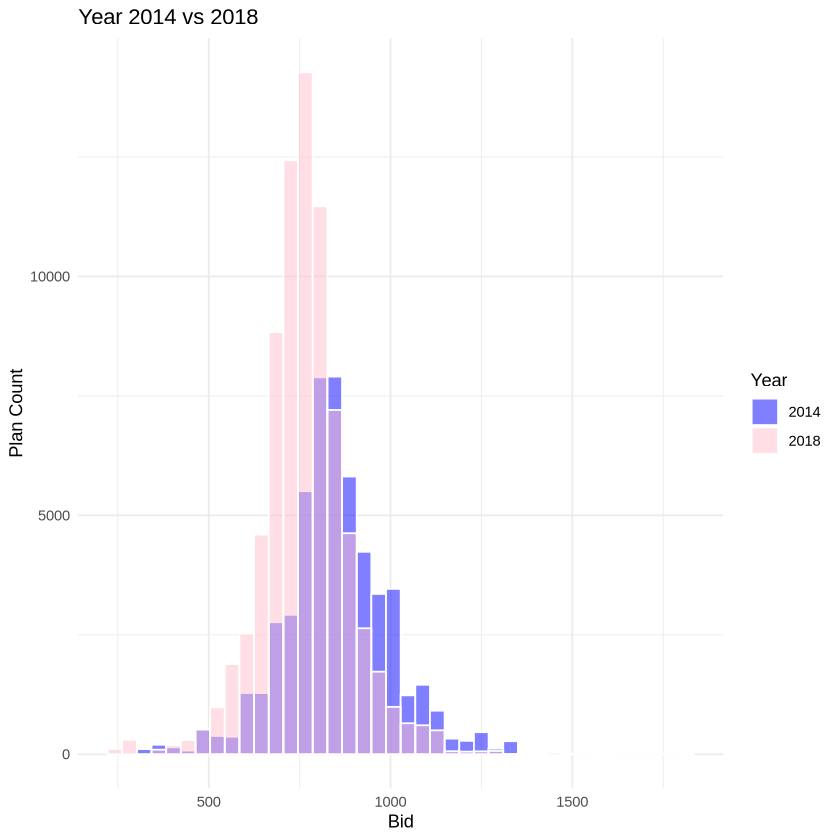

In [28]:
data.full %>%
  filter(year %in% c(2014, 2018)) %>%
  ggplot(aes(x = bid, fill = factor(year))) +
  geom_histogram(alpha = 0.5, bins = 40, position = "identity", color = "white") +
  scale_fill_manual(values = c("2014" = "blue", "2018" = "pink")) +
  labs(
    x = "Bid",
    y = "Plan Count",
    title = "Year 2014 vs 2018",
    fill = "Year"
  ) +
  theme_minimal()


## Problem 3


In [31]:
hhi_data <- data.full %>%
  mutate(share = avg_enrollment / avg_enrolled) %>%
  group_by(fips, year) %>%
  summarise(HHI = sum(share^2, na.rm = TRUE), .groups = "drop") %>% 
  group_by(year) %>% 
  summarise(mean_HHI = mean(HHI, na.rm = TRUE), .groups = "drop")

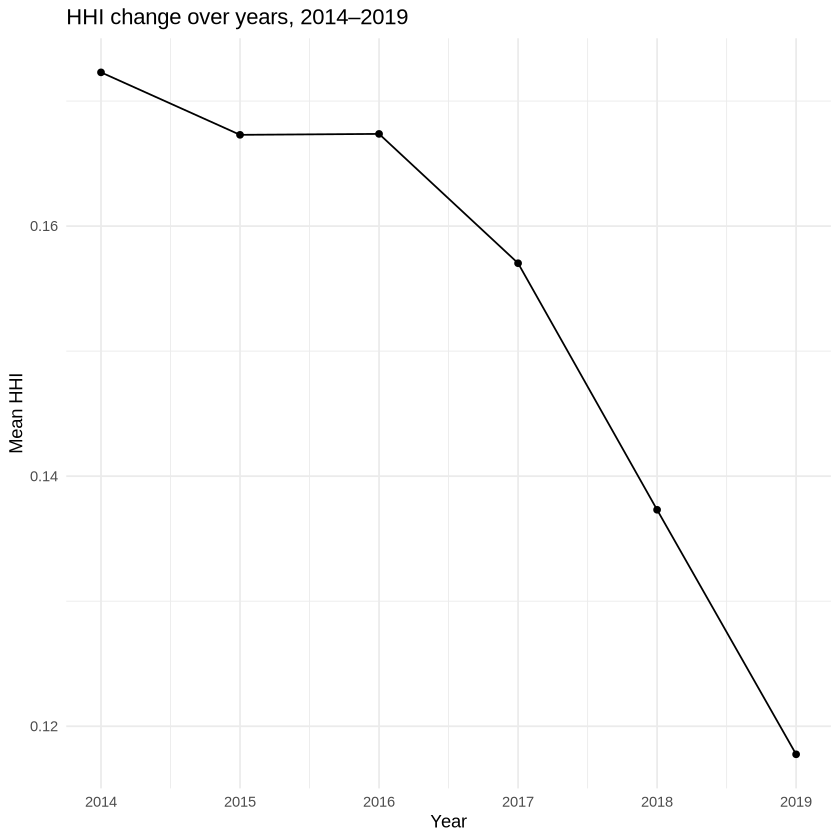

In [32]:
ggplot(hhi_data, aes(x = year, y = mean_HHI)) + geom_line() + geom_point() + theme_minimal() + labs(
    x = "Year",
    y = "Mean HHI",
    title = "HHI change over years, 2014–2019"
  )

## Problem 4


In [39]:
ma_share_yearly <- data.full %>%
    mutate(ma_share = avg_enrolled / avg_eligibles) %>%
    distinct(fips, year, .keep_all = TRUE) %>%
    group_by(year) %>%
    summarise(mean_share = weighted.mean(ma_share, w = avg_eligibles, na.rm = TRUE), .groups = "drop")

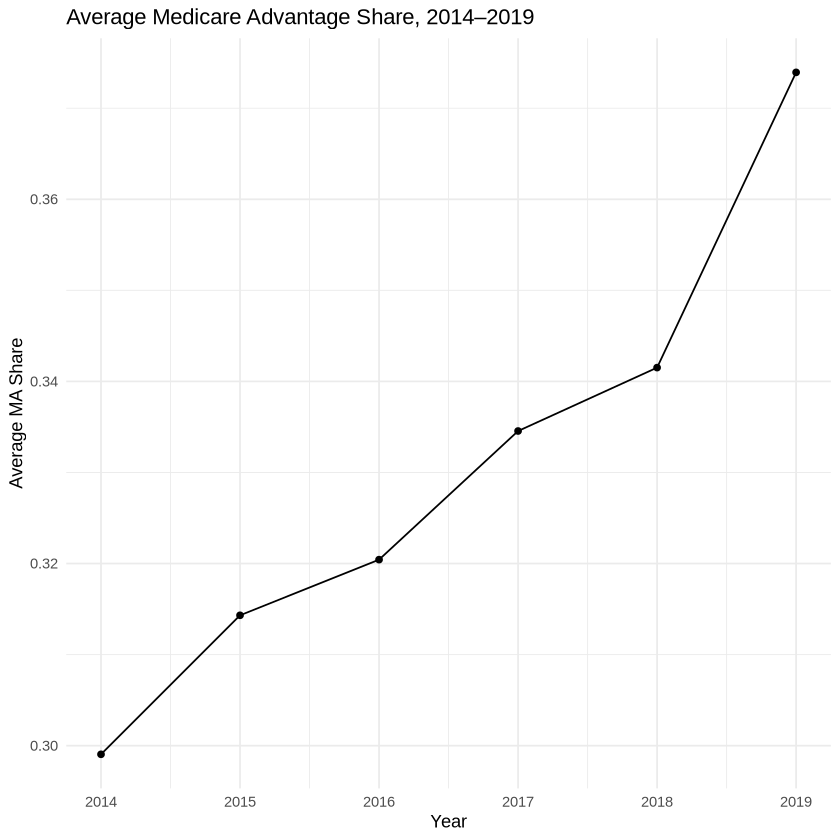

In [40]:
ggplot(ma_share_yearly, aes(x = year, y = mean_share)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  labs(
    x = "Year",
    y = "Average MA Share",
    title = "Average Medicare Advantage Share, 2014–2019"
  )

# Estimate ATEs

## Problem 5


In [53]:
data.2018 <- read.csv('../data/output/data-2018-ffs.csv')

In [54]:
ma.share.2018 <- data.2018 %>%
    filter(!is.na(avg_enrolled), avg_enrolled >  0) %>%
    filter(!is.na(avg_enrollment), avg_enrollment > 0) %>%
    group_by(fips, year) %>%
    mutate(ma_share = avg_enrollment / avg_enrolled) %>%
    ungroup()

In [55]:
market.2018 <- ma.share.2018 %>%
    group_by(fips) %>%
    summarize(hhi = sum(ma_share^2, na.rm = TRUE),
              bid = mean(bid, na.rm = TRUE),
              avg_ffscost = mean(avg_ffscost, na.rm = TRUE),
              avg_eligibles = mean(avg_eligibles, na.rm = TRUE),
              .groups = "drop")

In [56]:
hhi_data_33 <- quantile(market.2018$hhi, 0.33, na.rm = TRUE)
hhi_data_66 <- quantile(market.2018$hhi, 0.66, na.rm = TRUE)

In [58]:
market.2018 <- market.2018 %>%
    mutate(market_type = case_when(
        hhi <= hhi_data_33 ~ "Competitive",
        hhi >= hhi_data_66 ~ "Uncompetitive",
        TRUE ~ NA_character_))

In [61]:
avg_bid_by_market <- market.2018 %>%
    filter(!is.na(market_type), !is.na(bid)) %>%
    group_by(market_type) %>%
    summarize(avg_bid = mean(bid, na.rm = TRUE), n_markets = n(), .groups = "drop")

In [62]:
avg_bid_by_market

market_type,avg_bid,n_markets
<chr>,<dbl>,<int>
Competitive,782.8623,961
Uncompetitive,788.3218,915


## Problem 6


In [67]:
market.2018 <- market.2018 %>%
    mutate(
        treated = case_when(
            market_type == "Uncompetitive" ~ "Treated (high HHI)",
            market_type == "Competitive" ~ "Control (low HHI)",
            TRUE ~ NA_character_
        ))

In [69]:
cuts <- quantile(market.2018$avg_ffscost, probs = c(0, .25, .5, .75, 1), na.rm = TRUE)

market.2018$ffs_q <- cut(
    market.2018$avg_ffscost, 
    breaks = cuts, 
    include.lowest = TRUE,
    labels = 1:4)

market.2018 <- market.2018 %>%
  mutate(
    ffs_q1 = as.integer(ffs_q == "1"),
    ffs_q2 = as.integer(ffs_q == "2"),
    ffs_q3 = as.integer(ffs_q == "3"),
    ffs_q4 = as.integer(ffs_q == "4")
  )

In [71]:
market.2018 %>%
  filter(!is.na(treated), !is.na(ffs_q)) %>%
  group_by(treated, ffs_q) %>%
  summarize(mean_bid = mean(bid, na.rm = TRUE)) %>%
  tidyr::pivot_wider(
    names_from = treated,
    values_from = mean_bid,
    names_prefix = "bid_"
  )

`summarise()` has grouped output by 'treated'. You can override using the
`.groups` argument.


ffs_q,bid_Control (low HHI),bid_Treated (high HHI)
<fct>,<dbl>,<dbl>
1,788.8078,814.5570
2,784.2709,780.4974
3,775.1945,765.6627
4,783.9680,784.8341


# Problem 7


In [72]:
options(repos = c(CRAN = "https://cloud.r-project.org"))
install.packages("Matching")

Installing package into ‘/home/ssark38/R/x86_64-conda-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Warning message in install.packages("Matching"):
“installation of package ‘Matching’ had non-zero exit status”


In [73]:
market.2018 <- market.2018 %>%
  filter(!is.na(bid), !is.na(market_type), 
         !is.na(ffs_q),!is.na(ffs_q1), !is.na(ffs_q2), !is.na(ffs_q3), !is.na(ffs_q4))
     

In [75]:
ate_inv_var <- Matching::Match(Y=market.2018$bid,
                Tr=as.integer(market.2018$market_type == "Uncompetitive"),
                X= (market.2018 %>% select(ffs_q1, ffs_q2, ffs_q3, ffs_q4)),
                M=1,
                Weight=1,
                version = "fast",
                estimand="ATE")

Increasing memory because of ties: allocating a matrix of size 3 times 375000 doubles.
I would be faster with the ties=FALSE option.


Warning message in MatchLoopCfast(N = s1$N, xvars = Kx, All = s1$All, M = s1$M, :
“Increasing memory because of ties.  I would be faster with the ties=FALSE option.”


Increasing memory because of ties: allocating a matrix of size 3 times 562500 doubles.
I would be faster with the ties=FALSE option.


Warning message in MatchLoopCfast(N = s1$N, xvars = Kx, All = s1$All, M = s1$M, :
“Increasing memory because of ties.  I would be faster with the ties=FALSE option.”


In [102]:
print(ate_inv_var$est)

         [,1]
[1,] 3.299348


In [77]:
ate_mah <- Matching::Match(Y=market.2018$bid,
                          Tr=as.integer(market.2018$market_type == "Uncompetitive"),
                          X= (market.2018 %>% select(ffs_q1, ffs_q2, ffs_q3, ffs_q4)),
                          M=1,
                          Weight=2,
                          version = "fast",
                          estimand="ATE")
     

Increasing memory because of ties: allocating a matrix of size 3 times 375000 doubles.
I would be faster with the ties=FALSE option.


Warning message in MatchLoopCfast(N = s1$N, xvars = Kx, All = s1$All, M = s1$M, :
“Increasing memory because of ties.  I would be faster with the ties=FALSE option.”


Increasing memory because of ties: allocating a matrix of size 3 times 562500 doubles.
I would be faster with the ties=FALSE option.


Warning message in MatchLoopCfast(N = s1$N, xvars = Kx, All = s1$All, M = s1$M, :
“Increasing memory because of ties.  I would be faster with the ties=FALSE option.”


In [101]:
print(ate_mah$est)

         [,1]
[1,] 3.299348


In [80]:
market.2018 <- market.2018 %>% mutate(treat = as.integer(market_type == "Uncompetitive"))

In [84]:
logit.model <- glm(treat ~ ffs_q1 + ffs_q2 + ffs_q3 + ffs_q4, family = binomial, data = market.2018)
market.2018$ps <- fitted(logit.model)

market.2018 <- market.2018 %>%
  mutate(ipw = case_when(
    treat == 1 ~ 1/ps,
    treat == 0 ~ 1/(1 - ps)
  ))

mean.w1 <- market.2018 %>%
  filter(treat == 1) %>%
  summarize(mean_y = weighted.mean(bid, ipw))

mean.w0 <- market.2018 %>%
  filter(treat == 0) %>%
  summarize(mean_y = weighted.mean(bid, ipw))

ate_ipw <- mean.w1$mean_y - mean.w0$mean_y

In [85]:
print(ate_ipw)

[1] 3.299348


In [87]:
reg1 <- lm(bid ~ ffs_q1 + ffs_q2 + ffs_q3 + ffs_q4, data = market.2018 %>% filter(treat == 1))
reg0 <- lm(bid ~ ffs_q1 + ffs_q2 + ffs_q3 + ffs_q4, data = market.2018 %>% filter(treat == 0))

pred1 <- predict(reg1, newdata = market.2018)
pred0 <- predict(reg0, newdata = market.2018)

ate_regression <- mean(pred1 - pred0)

In [88]:
print(ate_regression)

[1] 3.299348


## Problem 8. 

ATE calculated with all the method estimators are the same, indicating validity.

In [91]:
results_table <- data.frame(
  ate_inv_var = ate_inv_var$est,
  ate_mahalanobis = ate_mah$est, 
  ate_ipw = ate_ipw,
  ate_regression = ate_regression
)

results_table

ate_inv_var,ate_mahalanobis,ate_ipw,ate_regression
<dbl>,<dbl>,<dbl>,<dbl>
3.299348,3.299348,3.299348,3.299348


## Problem 9. 

We will use my favorite Mahalanobis distance on total Medicare beneficiaries alongside the FFS quartile.


In [98]:
ate_mah_new <- Matching::Match(
  Y = market.2018$bid,
  Tr = as.integer(market.2018$market_type == "Uncompetitive"),
  X = (market.2018%>% select(avg_ffscost, avg_eligibles)),
  M = 1,
  Weight = 2,
  version = "fast",
  estimand = "ATE"
)

In [100]:
print(ate_mah_new$est)

         [,1]
[1,] 4.902514


The absolute value of ATE has gone up when the total number of Medicare beneficiaries is included as a covariate. It is still comparable to ATE obtained via inverse distance weighing or Mahalanobis as opposed to IPW or regression, which are approximately 0.

## Problem 10

My experience was fulfilling working with these large data chunks; it really completed my prior experiences. One thing I learned is that my code runs much cleaner and is easier to navigate, as I built most of it from class notes, my concepts, and simple structural logic, rather than using LLMs that I genuinely use strictly for my personal use. One thing that surprised me was how strenuous data management could be when I had to change file names and column ranges while creating cumulative data files for each year, and generalizable RegEx expressions couldn't be deployed.
